In [12]:
!pip install wandb
import wandb
wandb.login()
wandb.require("core")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


# get the model

In [13]:
run = wandb.init(
    project="hutech_mushroom",
    job_type="test",
)

In [14]:
id = "convnext-model:v89"
artifact_model = run.use_artifact(
    f"hutech_mushroom/{id}",
    type="model",
)
airtifact_model_dir = artifact_model.download()

wandb: Downloading large artifact convnext-model:v89, 188.79MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:12.1


In [15]:
print("Artifact downloaded to:", airtifact_model_dir)

Artifact downloaded to: /mnt/c/Users/beeha/VSCode/! - Self-study/All HUGE Projects/Computer Vision/hutech_mushroom/src/artifacts/convnext-model:v89


In [16]:
import torch
import torchvision.transforms as transforms


import os
import wandb

# src function

## helper

from utils.helper import get_model

- inference on CPU

In [17]:
model = get_model("convnext", num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvNeXt(
  (model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps

In [18]:
# airtifact_model_dir = "../models/"
# model.load_state_dict(torch.load(os.path.join(airtifact_model_dir, "best-vit-2025-03-31-13:00:20.pt")))
model_name = os.listdir(airtifact_model_dir)
print(model_name)
model.load_state_dict(torch.load(os.path.join(airtifact_model_dir, model_name[0])))

# model.load_state_dict(torch.load("../models/best-resnet-2025-03-30-23:18:30.pt"))
# state_dict = torch.load(os.path.join(airtifact_model_dir, "best-resnet-2025-03-30-22:51:06.pt"))



['best-convnext-2025-04-05-02:54:37.pt']


<All keys matched successfully>

- try a sample

tensor([[-2.9976,  1.7661, -2.9635,  3.7326]], device='cuda:0')
3


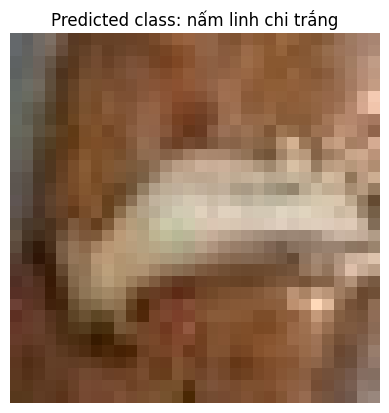

In [19]:
from PIL import Image, ImageFilter

image_path = "../final_test/066.jpg"

class EdgeEnhance(object):
    def __call__(self, image):
        # You can experiment between EDGE_ENHANCE and FIND_EDGES
        return image.filter(ImageFilter.EDGE_ENHANCE)

transform = transforms.Compose([
    transforms.RandomApply([EdgeEnhance()], p=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

with torch.no_grad():
    image = Image.open(image_path)
    img_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    output = model(img_tensor)
    print(output)
    _, predicted = torch.max(output, 1)
    print(predicted.item())  # Print the predicted class index

classes = {
    0: "nấm mỡ",
    1: "nấm bào ngư",
    2: "nấm đùi gà",
    3: "nấm linh chi trắng",
}
# plot 
import matplotlib.pyplot as plt
import numpy as np
import cv2

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted class: {classes[predicted.item()]}")
plt.show()


- create .csv file

In [20]:
import os
import glob
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomApply([EdgeEnhance()], p=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# classes' name
classes = {
    0: "nấm mỡ",
    1: "nấm bào ngư",
    2: "nấm đùi gà",
    3: "nấm linh chi trắng",
}

def predict(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

test_dir = "../final_test"
image_files = glob.glob(os.path.join(test_dir, "*.*"))

table = wandb.Table(columns=["image", "class"])

results = []
start = time.time()
for image_path in image_files:
    image_id = os.path.basename(image_path).replace(".jpg", "")
    pred_class_idx = predict(image_path, model, transform, device)
    results.append({"id": image_id, "type": pred_class_idx}) 
    table.add_data(wandb.Image(image_path), classes[pred_class_idx])

end = time.time()
print("Time taken for prediction:", end - start)
# Create a DataFrame from the results and export to CSV
df = pd.DataFrame(results)
df.to_csv("kaggle_submission.csv", index=False)
print("Submission file saved as kaggle_submission.csv")
run = wandb.init(
    project="hutech_mushroom_submission",
    job_type="test",
)

# upload to wandb 
run.log({"table": table})

artifact = wandb.Artifact("submission", type="table")

Time taken for prediction: 25.606918811798096
Submission file saved as kaggle_submission.csv


In [21]:
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
for i in range(0, 50):
    if results[i]["type"] == 1:
        count_1 += 1
for i in range(50, 100):
    if results[i]["type"] == 2:
        count_2 += 1
for i in range(100, 150):
    if results[i]["type"] == 3:
        count_3 += 1
for i in range(150, 200):
    if results[i]["type"] == 0:
        count_0 += 1    
print("Count of class 1:", count_1)
print("Count of class 2:", count_2)
print("Count of class 3:", count_3)
print("Count of class 0:", count_0)
print("Accuracy:", (count_0 + count_1 + count_2 + count_3) / 200)

Count of class 1: 50
Count of class 2: 25
Count of class 3: 50
Count of class 0: 48
Accuracy: 0.865


In [22]:
# artifact.add(table, "submission")
# run.log_artifact(artifact)
# artifact.wait()
# print("Artifact uploaded to wandb")
# run.finish()